In [49]:
# importing libraries
from rectipy import Network, random_connectivity
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, norm
from scipy.signal import find_peaks
import yaml

## Define distribution and parameters

In [50]:
# generate the lorenzian distribution
def lorentzian(n: int, eta: float, delta: float, lb: float, ub: float):
    samples = np.zeros((n,))
    for i in range(n):
        s = cauchy.rvs(loc=eta, scale=delta)  # stands for random variates
        while s <= lb or s >= ub:             # MC (rejection) sampling 
            s = cauchy.rvs(loc=eta, scale=delta)
        samples[i] = s
    return samples

In [51]:
# necessary parameters for the adex.
# model parameters
N = 1000
p = 0.2
C = 100.0
k = 0.7
v_r = -60.0
v_t = -40.0
Delta = 2.5
eta = 0.0
a = 0.03
b = -2.0
d = 10.0
g = 15.0
E_r = 0.0
tau_s = 6.0
v_spike = 1000.0
v_reset = -1000.0
# Add additional parameters for the AdEx model
C_adex = 281.0
delta_T = 2.0
a_adex = 4.0
b_adex = 80.5
tau_w = 144.0

In [52]:
# define inputs
T = 2500.0
cutoff = 500.0
dt = 1e-2
dts = 1e-1
inp = np.zeros((int(T/dt), 1)) + 25.0
inp[:int(cutoff*0.5/dt), 0] -= 15.0
inp[int(750/dt):int(2000/dt), 0] += 30


In [53]:
# define lorentzian of etas
thetas = lorentzian(N, eta=v_t, delta=Delta, lb=v_r, ub=0.0)

# define connectivity
W = random_connectivity(N, N, p, normalize=True)

## Running the Models

In [54]:
## ADEX VERSION
node_vars_adex = { "eta": eta, "v_r": v_r, "delta_T" : delta_T,  "v_theta": thetas,  "E_r": E_r, 
                  "C": C_adex, "a": a_adex, "b": b_adex, "tau_w": tau_w, "g": g, "tau_s": tau_s, "v" : v_t}


# initialize model
net = Network(dt=dt, device="cpu")  # we need to change all the node vars etc for the adex model
net.add_diffeq_node("snn", "/Users/utilizator/Desktop/gast_paper/config/adex_snn/rs", weights=W, source_var="s", target_var="s_in",
                    input_var="I_ext", output_var="s", spike_var="spike", reset_var="v", to_file=False,
                    node_vars=node_vars_adex.copy(), op="rs_op", spike_reset=v_reset, spike_threshold=v_spike,
                    verbose=False, clear=True, device="cuda:0")

# perform simulation
obs = net.run(inputs=inp, sampling_steps=int(dts/dt), record_output=True, verbose=True, cutoff=int(cutoff/dt))
res_snn_adex = obs.to_dataframe("out")

Progress: 50000/250000 integration steps finished.
Progress: 50010/250000 integration steps finished.
Progress: 50020/250000 integration steps finished.
Progress: 50030/250000 integration steps finished.
Progress: 50040/250000 integration steps finished.
Progress: 50050/250000 integration steps finished.
Progress: 50060/250000 integration steps finished.
Progress: 50070/250000 integration steps finished.
Progress: 50080/250000 integration steps finished.
Progress: 50090/250000 integration steps finished.
Progress: 50100/250000 integration steps finished.
Progress: 50110/250000 integration steps finished.
Progress: 50120/250000 integration steps finished.
Progress: 50130/250000 integration steps finished.
Progress: 50140/250000 integration steps finished.
Progress: 50150/250000 integration steps finished.
Progress: 50160/250000 integration steps finished.
Progress: 50170/250000 integration steps finished.
Progress: 50180/250000 integration steps finished.
Progress: 50190/250000 integrat

In [55]:
# initialize model
node_vars_ik = {"C": C, "k": k, "v_r": v_r, "v_theta": thetas, "eta": eta, "tau_u": 1/a, "b": b, "kappa": d,
             "g": g, "E_r": E_r, "tau_s": tau_s, "v": v_t}

# initialize model
net = Network(dt=dt, device="cpu")  # we need to change all the node vars etc for the adex model
net.add_diffeq_node("snn", "/Users/utilizator/Desktop/gast_paper/config/ik_snn/rs", weights=W, source_var="s", target_var="s_in",
                    input_var="I_ext", output_var="s", spike_var="spike", reset_var="v", to_file=False,
                    node_vars=node_vars_ik.copy(), op="rs_op", spike_reset=v_reset, spike_threshold=v_spike,
                    verbose=False, clear=True, device="cuda:0")

# perform simulation
obs = net.run(inputs=inp, sampling_steps=int(dts/dt), record_output=True, verbose=True, cutoff=int(cutoff/dt))
res_snn_ik = obs.to_dataframe("out")


Progress: 50000/250000 integration steps finished.
Progress: 50010/250000 integration steps finished.
Progress: 50020/250000 integration steps finished.
Progress: 50030/250000 integration steps finished.
Progress: 50040/250000 integration steps finished.
Progress: 50050/250000 integration steps finished.
Progress: 50060/250000 integration steps finished.
Progress: 50070/250000 integration steps finished.
Progress: 50080/250000 integration steps finished.
Progress: 50090/250000 integration steps finished.
Progress: 50100/250000 integration steps finished.
Progress: 50110/250000 integration steps finished.
Progress: 50120/250000 integration steps finished.
Progress: 50130/250000 integration steps finished.
Progress: 50140/250000 integration steps finished.
Progress: 50150/250000 integration steps finished.
Progress: 50160/250000 integration steps finished.
Progress: 50170/250000 integration steps finished.
Progress: 50180/250000 integration steps finished.
Progress: 50190/250000 integrat

## Ploting the results

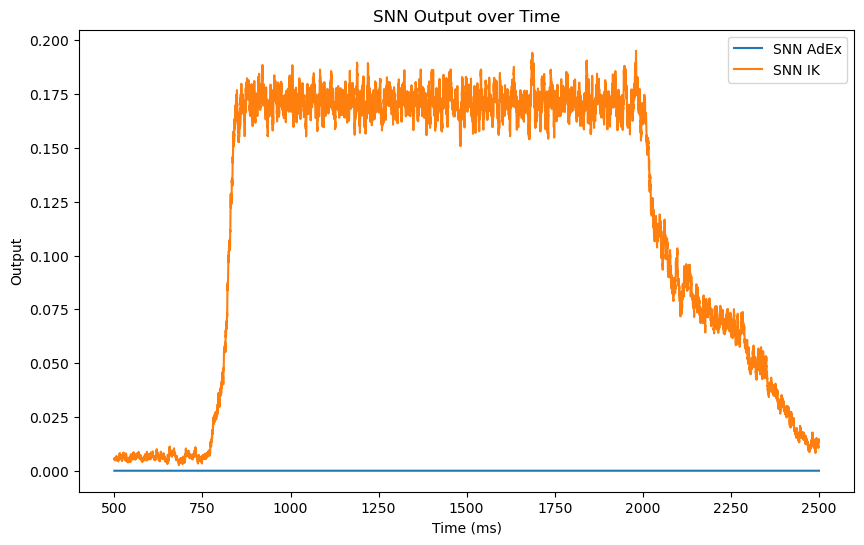

In [56]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(res_snn_adex.index, np.mean(res_snn_adex, axis=1), label='SNN AdEx')
plt.plot(res_snn_ik.index, np.mean(res_snn_ik, axis=1), label='SNN IK')
plt.xlabel('Time (ms)')
plt.ylabel('Output')
plt.title('SNN Output over Time')
plt.legend()
plt.show()